In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from prediction_strength import prediction_strength
from sklearn.model_selection import train_test_split
import numpy as np

### 1. Open and read the provided data file.

In [3]:
df = pd.read_csv("data/data.csv", delimiter=';')

### 2. Determine and display the number of records.

In [4]:
df.shape

(1599, 12)

#### Let't look at the imbalance of the quality classes before deleting this attribute from the dataset.

In [5]:
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

### 3. Remove the quality attribute.

In [6]:
df = df.drop('quality', axis=1)

### 4. Display the remaining attributes.

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### 5. Using the KMeans function of the scikit-learn library, partition the data set into clusters with random initial initialization and display the coordinates of the cluster centers.

#### The optimal number of clusters can be determined based on the initial data set in three different ways:

- elbow method

- average silhouette method

- prediction strength method

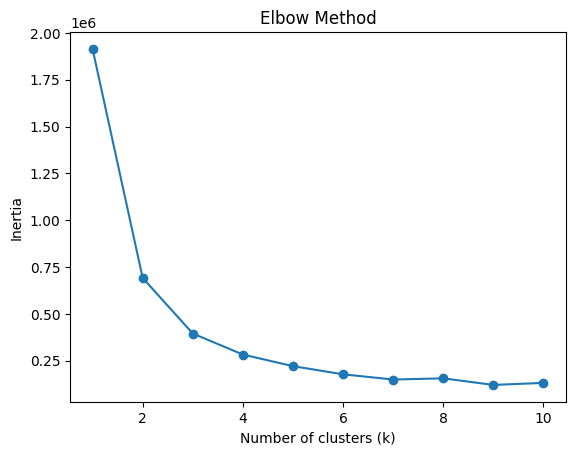

In [8]:
# elbow method
inertia = []

for k in range(1, 11):
    model = KMeans(n_clusters=k, init='random', random_state=1)
    model.fit(df)
    inertia.append(model.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


#### So, the optimal number of clusters according to the elbow method can be considered 3 or 4. This can be explained by the fact that we have two very large groups (5, 6) and one moderate (7), the separation of which gives a significant reduction in inertia. The other small ones (4, 8, 3) have few points and adding clusters to them does not change the inertia value significantly.

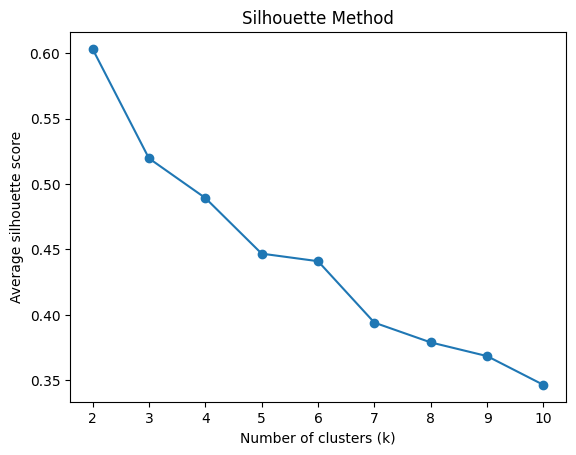

In [9]:
# average silhouette method
average_silhouette = []

for k in range(2, 11):
    model = KMeans(n_clusters=k, init='random', random_state=1)
    model.fit(df)
    average_silhouette.append(silhouette_score(df, model.labels_))

plt.plot(range(2, 11), average_silhouette, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average silhouette score')
plt.title('Silhouette Method')
plt.show()


#### The optimal number of clusters according to the average silhouette method can be considered 3 or 4. The Silhouette Method evaluates the quality of clustering based on two values ​​for each point: 
1. The average distance to other points in its cluster (the smaller this distance, the better the points are grouped)
2. The average distance to the points of the nearest other cluster (the larger this distance, the better the cluster is separated)

#### We see that when new clusters are added, the average distance between points in one cluster increases, and the average distance to points in the nearest other cluster decreases, i.e., the clusters become less clearly separated.

In [13]:
# prediction strength method
results = []
for i in range(20):
    X_train, X_test = train_test_split(df, test_size=1/2, random_state=i)

    ps_i_avg = []
    for k in range(2, 11):
        scores = []
        for seed in range(30):
            model_train = KMeans(n_clusters=k, init='random', random_state=seed).fit(X_train)
            model_test = KMeans(n_clusters=k, init='random', random_state=seed).fit(X_test)
            
            score = prediction_strength(model_train.predict(X_test), model_test.labels_)
            scores.append(score)
        ps_i_avg.append(np.mean(scores))
    results.append(ps_i_avg)


prediction_strengths_avg = []
for result in np.array(results).T:
    prediction_strengths_avg.append(np.mean(result))

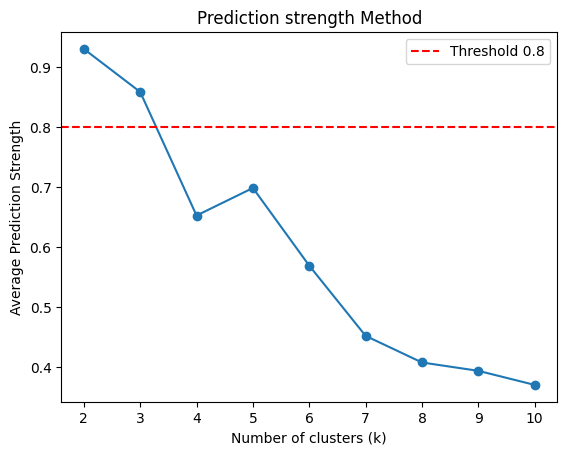

In [16]:
plt.plot(range(2, 11), prediction_strengths_avg, marker='o')
plt.axhline(y=0.8, color='red', linestyle='--', label='Threshold 0.8')
plt.legend()
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Prediction Strength')
plt.title('Prediction strength Method')
plt.show()

#### So, the optimal number of clusters according to prediction strength can be considered 3 (prediction strength > 0.8). But we also see that at k = 5 the model becomes more stable than at k = 4, and better separates smaller groups that otherwise merge. For final model we will use 3 clusters.

In [18]:
kmeans = KMeans(n_clusters=3, init='random', random_state=1)
kmeans.fit(df)

print("Coordinates of cluster centers:")
print(kmeans.cluster_centers_)

Coordinates of cluster centers:
[[8.46982759e+00 5.19519704e-01 2.68608374e-01 2.36102217e+00
  8.46059113e-02 8.99507389e+00 2.23928571e+01 9.96617512e-01
  3.31137931e+00 6.47216749e-01 1.05769294e+01]
 [7.88755187e+00 5.72365145e-01 2.75643154e-01 3.23236515e+00
  8.83983402e-02 2.61514523e+01 1.08506224e+02 9.96934730e-01
  3.28962656e+00 6.52033195e-01 1.00089212e+01]
 [8.28699634e+00 5.20503663e-01 2.72435897e-01 2.49706960e+00
  9.13095238e-02 2.15705128e+01 5.48882784e+01 9.96855769e-01
  3.32020147e+00 6.77106227e-01 1.03768010e+01]]


### 6. For the previously selected number of clusters, perform clustering multiple times using the k-means method, using the k-means++ method for initial initialization. Select the best clustering option. What quantitative criterion did you choose to select the best clustering?

In [22]:
best_silhouette_score = 0
best_model = None

for random_state in range(100):  
    model = KMeans(n_clusters=3, init='k-means++', random_state=random_state)
    model.fit(df)  
    
    score = silhouette_score(df, model.labels_)
    if score > best_silhouette_score:
        best_silhouette_score = score
        best_model = model


print("Coordinates of cluster centers:")
print(best_model.cluster_centers_)
print(f"Silhouette Score: {best_silhouette_score}")

Coordinates of cluster centers:
[[8.02316785e+00 5.51158392e-01 2.81843972e-01 2.90721040e+00
  9.30756501e-02 2.55898345e+01 9.04515366e+01 9.96957329e-01
  3.30021277e+00 6.63286052e-01 1.00870764e+01]
 [8.42717206e+00 5.19799830e-01 2.66362862e-01 2.39625213e+00
  8.55093697e-02 1.23377342e+01 3.02163543e+01 9.96676891e-01
  3.31555366e+00 6.56550256e-01 1.05408149e+01]
 [7.90000000e+00 3.00000000e-01 6.80000000e-01 8.30000000e+00
  5.00000000e-02 3.75000000e+01 2.83500000e+02 9.93160000e-01
  3.01000000e+00 5.10000000e-01 1.23000000e+01]]
Silhouette Score: 0.6029703479946892


#### To select the best clustering I used the silhouette score, since this metric simultaneously evaluates both the compactness of objects within the same cluster and the separation between clusters. The best clustering achieved a silhouette score of 0.60.

### 7. Using the AgglomerativeClustering function of the scikit-learn library, divide the data set into clusters. Choose the same number of clusters as in the previous method. Output the coordinates of the cluster centers.

In [ ]:
model_agglo = AgglomerativeClustering(n_clusters=3)
model_agglo_labels = model_agglo.fit_predict(df)

cluster_centers = np.array([df[model_agglo_labels == i].mean(axis=0) for i in range(3)])
print("Coordinates of cluster centers:")
print(cluster_centers)

print(f"Silhouette Score: {silhouette_score(df, model_agglo_labels)}")

Coordinates of cluster centers:
[[8.17088608e+00 5.30126582e-01 2.56315049e-01 2.42932489e+00
  9.04345992e-02 1.95872011e+01 5.26104079e+01 9.96791139e-01
  3.33443038e+00 6.65907173e-01 1.03732771e+01]
 [7.98047619e+00 5.57595238e-01 2.88904762e-01 3.36285714e+00
  8.99380952e-02 2.86547619e+01 1.11342857e+02 9.96993524e-01
  3.27071429e+00 6.59047619e-01 9.97658730e+00]
 [8.58067847e+00 5.16179941e-01 2.80796460e-01 2.39837758e+00
  8.35884956e-02 8.02359882e+00 1.99321534e+01 9.96623599e-01
  3.29917404e+00 6.49734513e-01 1.06133727e+01]]
Silhouette Score: 0.4739848424898087


#### KMeans achieves a higher silhouette score at n_clusters=3 (0.60 vs. 0.47), indicating better cluster separation and compactness compared to the AgglomerativeClustering method.